# Evaluation MIAS Data Science / Machine Learning #
---
Cours de Mr Salem

Groupe : Victor Bonlieu-Fortier, Saliou Niang, Charles Nikdel

---

---

## Introduction ##

Le but de notre tâche est de classifier les tweets, si ils sont offensifs ou non.

Nous avons un datasets de tweeter avec 29530 Tweet dont 2242 offensifs.

Notre premier plan, est d'explorer les données, faire un peu de traitement dessus et directement essayer de faire une prédiction. Cela ne sera surement pas efficace, mais vu la faible taille du datasets, cela nous permettra de se faire un peu plus la main sur la manipulation de string au sein de DataFrame et de l'explorer un peu plus.


## Premier essai : ##
---

Nous faisons les imports que nous pensons nécessaire pour le traitement du dataset.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

On extrait les données du csv pour les mettre dans un DataFrame.

Etant donnée qu'il y a déjà une colonne id dans le datasets, on le mets en index pour ne pas avoir une colonne inutile.



In [109]:
data_clean = pd.read_csv("train.csv")
df = pd.DataFrame(data=data_clean.copy(), index=data_clean["id"])
df.drop("id", axis=1, inplace=True)

### Observation de données ###
On va commencer par l'observation du datasets.

On remarque que le datasets est déséquilibré
Que ce sont des tweets mis en forme c'est à dire: anonymisé, tout les @ sont user, tout en minuscule, et des problèmes de traduction des émojis, du coup à traduire aussi

In [110]:
df.shape

(31962, 2)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   31961 non-null  float64
 1   tweet   31961 non-null  object 
dtypes: float64(1), object(1)
memory usage: 749.1+ KB


In [112]:
df.describe()

,label
count,31961.000000
mean,0.070148
std,0.255400
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [113]:
df["label"].value_counts()

0.0 29719
1.0 2242
Name: label, dtype: int64

In [114]:
df.head()

,label,tweet
id,,
1,0.0,@user @user thanks for #lyft credit i can't us...
2,0.0,bihday your majesty
3,0.0,#model i love u take with u all the time in ...
4,0.0,factsguide: society now #motivation
5,0.0,[2/2] huge fan fare and big talking before the...


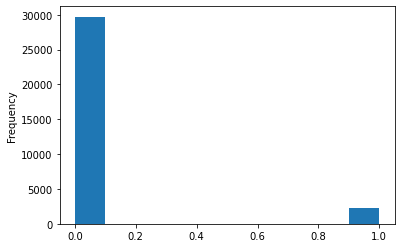

In [115]:
df["label"].plot.hist()
plt.show()

In [116]:
#observons les termes les plus fréquents du dataset
def create_corpus(texts):
    corpus = []
    for text in texts:
        text=str(text)
        for t in text.split():
            corpus.append(t)
    return pd.DataFrame(corpus)
nltk.download('stopwords')

stops = stopwords.words("english")
stops.append("@user") #on retire @user car on sait que c'est le terme le plus fréquent
df_words=create_corpus(df['tweet'])
relevant_words=[word for word in df_words[0] if word.lower() not in stops]
pd.DataFrame(relevant_words).value_counts().head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


& 1574
day 1454
#love 1449
happy 1328
- 1244
dtype: int64

- Notre dataset contient les tweets et leur classification, 1 pour les tweets haineux et 0 pour les tweets normaux.
- Ils nous sera nécessaire de nettoyer les tweets, ceux-ci contiennent des caractères spéciaux non pertinent à la classification. 

In [117]:
df["label"].value_counts("normalize")

0.0 0.929852
1.0 0.070148
Name: label, dtype: float64

On constate que le dataset n'est pas du tout équilibré on pensera à tester différentes méthodes pour eviter ce problème (Over/UnderSampling, et Stratification).

In [118]:
df.dropna()
df.describe

<bound method NDFrame.describe of        label                                              tweet
id                                                             
1        0.0  @user @user thanks for #lyft credit i can't us...
2        0.0                                bihday your majesty
3        0.0  #model   i love u take with u all the time in ...
4        0.0             factsguide: society now    #motivation
5        0.0  [2/2] huge fan fare and big talking before the...
...      ...                                                ...
31958    0.0    to see nina turner on the airwaves trying to...
31959    0.0  listening to sad songs on a monday morning otw...
31960    1.0  @user #sikh #temple vandalised in in #calgary,...
31961    0.0                   thank you @user for you follow  
31962    NaN                                                NaN

[31962 rows x 2 columns]>

## Traitement de la donnée ##

Nous allons commencer à modifier et à extraire des données du dataframe.
Pour nous, voici les choses importantes pour nous:

- Retirer les @user (mention d'un utilisateur dans un tweet)
- Retirer les chiffres, la ponctuation afin d'être traiter  plus facilement par les algorithmes de Machine Learning.
- Isolé dans une autre colonne le nombres d'hashtag dans les tweets.
- Retirer les émojis (qui sont sous la forme de chaine de caractères spéciaux).

In [119]:
import unicodedata

def parserouquoi(s):
    stockeurw = []
    stockeurh = []
    stock = s.split(" ")
    for i in stock:
        if i == "@user":
            continue
        elif i.startswith('#'):
            # On retire les chiffres et les caractères spéciaux
            p = [l for l in i[1:] if l.isalpha()]
            p = "".join(p)
            if len(p) != 0:
                stockeurh.append(p)
        else :
            # Pour retirer tout le reste sauf les lettres
            p = [l for l in i if l.isalpha()]
            p = "".join(p)
            if len(p) != 0:
                stockeurw.append(p)
    # Supprimer les émojis
    h = unicodedata.normalize('NFKD', " ".join(stockeurh)).encode('ascii', 'ignore').decode('utf-8')
    w = unicodedata.normalize('NFKD', " ".join(stockeurw)).encode('ascii', 'ignore').decode('utf-8')

    return str(h),str(w)

On recupère alors une string contenant tout les mots et une autre contenant tout les hashtags.

Pour la suite, nous allons commencer à modifier le dataset, donc nous allons en faire une copie pour toujours se permettre un retour en arrière.

Maintenant que la fonction est faite, on va pouvoir l'appliquer avec la méthode apply() et une fonction lambda sur tout le dataframe.

In [120]:
dfc = df.copy()
dfc = dfc.dropna()

dfc[['hashtag', 'words']] = dfc.apply(lambda row: pd.Series(parserouquoi(row['tweet'])), axis=1)
dfc

,label,tweet,hashtag,words
id,,,,
1,0.0,@user @user thanks for #lyft credit i can't us...,lyft disapointed getthanked,thanks for credit i cant use cause they dont o...
2,0.0,bihday your majesty,,bihday your majesty
3,0.0,#model i love u take with u all the time in ...,model,i love u take with u all the time in ur
4,0.0,factsguide: society now #motivation,motivation,factsguide society now
5,0.0,[2/2] huge fan fare and big talking before the...,allshowandnogo,huge fan fare and big talking before they leav...
...,...,...,...,...
31957,0.0,ate @user isz that youuu?ðððððð...,,ate isz that youuuai
31958,0.0,to see nina turner on the airwaves trying to...,shame imwithher,to see nina turner on the airwaves trying to w...
31959,0.0,listening to sad songs on a monday morning otw...,,listening to sad songs on a monday morning otw...


Maintenant nous n'avons plus besoin de la colonne Tweet, pour rendre le dataset plus léger et ne pas avoir d'information redondante.

In [121]:
dfc.drop("tweet", axis = 1, inplace=True)

On crée les variables X et Y pour le train test split

In [122]:
Y = dfc["label"].copy()
X = dfc.drop("label",axis = 1)

On met bien le stratify sur Y vu que le set est imbalanced.

In [123]:
xtrain,xtest,ytrain,ytest = train_test_split(X , Y, stratify=Y)
ytest

id
31174 0.0
17714 0.0
15391 0.0
6896 0.0
10494 0.0
 ... 
8373 0.0
1079 1.0
3561 0.0
26624 0.0
3272 0.0
Name: label, Length: 7991, dtype: float64

On vérifie si c'est bien stratifier.

In [124]:
ytest.value_counts("normalize")

0.0 0.929796
1.0 0.070204
Name: label, dtype: float64

Comme le dataset est beacoup désiquilibré, nous avons peur qu'avec OverSample, le modèle fasse de l'overfitting.
Alors on a choisi UnderSample, ou SMOTE.

In [125]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(xtrain, ytrain)

On vérifie que maintenant le dataset est équilibré.

In [126]:
Y_resampled.value_counts("normalize")

0.0 0.5
1.0 0.5
Name: label, dtype: float64

On as eu pas mal d'erreur, grâce à stackOverflow et de la documentation, le problème provenais de l'orientation du DataFrame, nous n'avons pas trouvé

Nous avons alors utilisé la méthode transpose() pour échanger l'index et les colonnes pour faire marcher la pipeline.

In [127]:
X_resampled = X_resampled.transpose()
X_resampled.head()

id,2021,3612,6816,7944,9927,10622,24196,25937,14097,12103,...,22937,3882,29053,8374,1047,15207,31670,1751,11355,9342
hashtag,justmarried feeling,babies bouncingbaby,,pileupriddim,friday feeling live lifea,tennis crack character quote,macedonia,veryhotsummer goodday,fruits smoothie froosh beauty enjoy nice yummy,success motivation,...,problemofwhiteness snowflakes,mexicans lmao,,lazioa,zionazi,swastika bigotry newswithed,santa white newswithed,,,denzelwashington morganfreeman willsmith
words,photography secrets from one of the worldas to...,dream on me in lightweight poable folding conv...,for the fact that you keep watching makes it m...,first half done now the real half begins on th...,friday feeling live your life the way you wan...,life is like ball its amp bouncing till core d...,celebrates its th as it sinks the state deeper...,bbq,breakfast a,you want more allow me to help you get where y...,...,universityofwisconsinmadison offering course i...,i have to say i love me some even if is against,fair amp lovely effect,so far all the blog comments claim senad lulic...,todays donkey is proud of murdering real pales...,vandals turn a jewish familyas home menorah in...,why is always,no liberal believes that we are the pay of inc...,hitler called,why do the most wise words often come from bla...


Nous avons mis en place une Pipeline, casiment identique à celle de la documentation [le lien](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Nous avions aussi un problème de type avec les modèles, que l'on as due régler avec un typecast.

Dans notre pipeline, nous avons 3 élèments : 

**TfidfVectorizer** : Tf-idf veut dire  : "Term Frequency - Inverse Document Frequency". C'est tout simplement le nombre de fois que ce mot est apparu dans le document, à l'inverse du nombre de fois que le mot est apparu dans tout les autres documents.
C'est une bonne mesure pour le NLP parce que c'est adapté au dataset, cela permet d'en avoir son importance relative.

**TfidfTransformer()** : C'est un module spéciale pour normaliser les valeurs des vecteurs tfidf.

**MultinomialNB()** : C'est le multinomial Naive Bayes, il est dit que c'est un modèle adapté pour le NLP

In [128]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

X_resampled = [str(x) for x in X_resampled]

text_clf.fit(X_resampled,Y_resampled)

Pipeline(steps=[('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('vect', TfidfVectorizer()), ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())]) TfidfVectorizer TfidfVectorizer() TfidfTransformer TfidfTransformer() MultinomialNB MultinomialNB()

Avec le xtest, nous devons faire pareil, c'est à dire le typecast puis le transposer.

In [129]:
xtest = xtest.transpose()

Ensuite on prédit, et on vérifie que la prédiction contienne quelque chose.

In [130]:
xtest = [str(x) for x in xtest]
ypred = text_clf.predict(xtest)

In [131]:
ypred

array([0., 0., 0., ..., 0., 0., 0.])

Une fois la prédiction faites, on analyse la matrice de confusion et les mesures, on observe que ce mode de traitement n'est pas du tout efficace et que nous devons reprendre sur des meilleures bases avec plus de recherches en amont, pour au moins avoir un résultat acceptable (le résultat obtenue ne prédit que des positifs).

In [132]:
metrics.confusion_matrix(ytest, ypred)

array([[7430, 0],
 [ 561, 0]])

In [133]:
def ft_printeur(ytest,ypred):
    print(f"Accuraccy : { metrics.accuracy_score(ytest,ypred) } \n Precision : { metrics.precision_score(ytest,ypred) } \n F-1 Score : { metrics.precision_score(ytest,ypred) }")

In [134]:
ft_printeur(ytest,ypred)

Accuraccy : 0.9297960205230885 
 Precision : 0.0 
 F-1 Score : 0.0


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Les résusltats sont très mauvais, on se retrouve même avec une erreur du fait de la division par zéro...

## Deuxieme essai ##

Nous avons repris avec des bases plus solides et un plan plus précis.

On va commencer par isoler chaque parties pour voir un peu plus clair dans le dataset, puis les visualiser pour vérifier si il y a un moyen d'en ressortir quelque chose.

Par la suite le tokenifier (faire une séaration correct des mots) et supprimer plus de choses avec nltk, cela sera plus simple et plus rapide.

Nous allons aussi essayer de faire un petit peu plus optimisé, c'est à dire utiliser un peu plus les méthodes déjà implémentées dans les librairies

Lire plus de documentation pour avoir un plan plus précis de notre traitement de donnée.

Voici un peu les sources et la documentation que nous avons utilisé :

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://stackabuse.com/text-classification-with-python-and-scikit-learn/

https://vasista.medium.com/preparing-the-text-data-with-scikit-learn-b31a3df567e

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

https://www.geeksforgeeks.org/natural-language-processing-nlp-pipeline/

https://www.geeksforgeeks.org/processing-text-using-nlp-basics/

https://www.geeksforgeeks.org/natural-language-processing-moving-beyond-zeros-and-ones/

https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://scikit-learn.org/stable/index.html

Et d'autres documentations...

## Notre plan ##

Vu que nous savons déjà ce qui est dans le DataFrame, nous pouvons arriver plus rapidement à notre objectif.

Nous voulons créer des visualisations diverses et peut être trouvé une corrélation particulière.

Nos idées sont : 
- Le nombre de mot
- Le nombre de lettres
- Le nombre de lettres par mot en moyenne
- Le nombre de hashtags
- Le nombre de stopwords

Ensuite nous le traitons comme cela :
- On va retirer les stopwords
- Retirer les émojis
- Retirer les ponctuations
- Au vu de la documentation, une bonne idée est de retirer une valeur subjective des mots les plus répétés et des plus rares, pour réduire la sensibilitée aux outliers
- Ensuite on tokenize
- Vu que les phrases seront bien réduites, nous partirons plutôt sur un Lemmatizer pour avoir un meilleur résultats

#### Ouvrir le csv ####

In [135]:
df = pd.DataFrame(data=data_clean.copy(), index=data_clean["id"]) 
df.drop("id", axis = 1, inplace=True)
df

,label,tweet
id,,
1,0.0,@user @user thanks for #lyft credit i can't us...
2,0.0,bihday your majesty
3,0.0,#model i love u take with u all the time in ...
4,0.0,factsguide: society now #motivation
5,0.0,[2/2] huge fan fare and big talking before the...
...,...,...
31958,0.0,to see nina turner on the airwaves trying to...
31959,0.0,listening to sad songs on a monday morning otw...
31960,1.0,"@user #sikh #temple vandalised in in #calgary,..."


#### On retire les NaN ####

In [136]:
df.dropna(inplace=True) # on retire tout les NaN

#### On fait des nouvelles colonnes pour compter les mots et le nombres de lettres, puis on fait la moyenne ####

In [137]:
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split(" "))) # On crée une colonne avec le nombre de mots par tweets
df['letters_count'] = df['tweet'].apply(lambda x: len(str(x)))  # On une colonne avec la valeur totale de la longueure du tweet

In [138]:
df["mean_lpw"] = df["letters_count"] / df["word_count"] # On fait la moyenne de lettres par mots
df

,label,tweet,word_count,letters_count,mean_lpw
id,,,,,
1,0.0,@user @user thanks for #lyft credit i can't us...,22,122,5.545455
2,0.0,bihday your majesty,5,21,4.200000
3,0.0,#model i love u take with u all the time in ...,17,86,5.058824
4,0.0,factsguide: society now #motivation,8,39,4.875000
5,0.0,[2/2] huge fan fare and big talking before the...,21,116,5.523810
...,...,...,...,...,...
31957,0.0,ate @user isz that youuu?ðððððð...,6,68,11.333333
31958,0.0,to see nina turner on the airwaves trying to...,25,131,5.240000
31959,0.0,listening to sad songs on a monday morning otw...,15,63,4.200000


#### Gestion des Stopwords et hashtags ####

On retire les StopWords.

In [139]:
from nltk.corpus import stopwords # import de la librairie
nltk.download("stopwords")
stop = set(stopwords.words('english')) # On stock les stopwords dans une variable

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [140]:
df["stopwords"] = df["tweet"].apply(lambda x: len([x for x in str(x).split() if x in stop])) # On compte le nombre de stopwords
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords
id,,,,,,
1,0.0,@user @user thanks for #lyft credit i can't us...,22,122,5.545455,5
2,0.0,bihday your majesty,5,21,4.200000,1
3,0.0,#model i love u take with u all the time in ...,17,86,5.058824,5
4,0.0,factsguide: society now #motivation,8,39,4.875000,1
5,0.0,[2/2] huge fan fare and big talking before the...,21,116,5.523810,6
...,...,...,...,...,...,...
31957,0.0,ate @user isz that youuu?ðððððð...,6,68,11.333333,1
31958,0.0,to see nina turner on the airwaves trying to...,25,131,5.240000,9
31959,0.0,listening to sad songs on a monday morning otw...,15,63,4.200000,5


In [141]:
#   Retirer tous les mots commun des tweets :

from nltk.corpus import stopwords
nltk.download("stopwords")
stp = set(stopwords.words('english'))

def remove_stopwords(text:str):
    l = str.split(text)
    for word in str.split(text):
        if word in stop :
            l.remove(word)
    return " ".join(l)

df["tweet"] = df["tweet"].apply(lambda x :remove_stopwords(str(x)))
df

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,tweet,word_count,letters_count,mean_lpw,stopwords
id,,,,,,
1,0.0,@user @user thanks #lyft credit can't use caus...,22,122,5.545455,5
2,0.0,bihday majesty,5,21,4.200000,1
3,0.0,#model love u take u time urð±!!! ððð...,17,86,5.058824,5
4,0.0,factsguide: society #motivation,8,39,4.875000,1
5,0.0,[2/2] huge fan fare big talking leave. chaos p...,21,116,5.523810,6
...,...,...,...,...,...,...
31957,0.0,ate @user isz youuu?ððððððð...,6,68,11.333333,1
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5


In [142]:
df['hastags'] = df['tweet'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')])) # On compte le nombre de mots qui commence par un #
df 

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,@user @user thanks #lyft credit can't use caus...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,#model love u take u time urð±!!! ððð...,17,86,5.058824,5,1
4,0.0,factsguide: society #motivation,8,39,4.875000,1,1
5,0.0,[2/2] huge fan fare big talking leave. chaos p...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate @user isz youuu?ððððððð...,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


#### On retire la ponctuation ####

In [143]:
punct = string.punctuation # import de la librairie string, la liste de ponctuation

In [144]:
#punct = punct.replace("#","") # jgarde les hashtag parce que c'est tweeter
#punct # imprime

In [145]:
df["tweet"] = df["tweet"].apply(lambda x: str(x).translate(str.maketrans(punct, ' ' * len(punct)))) # ça ne marchais pas avec str.replace(), mais ici o retire la ponctuation avec les espaces
df 

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,user user thanks lyft credit can t use caus...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model love u take u time urð± ððð...,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,2 2 huge fan fare big talking leave chaos p...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate user isz youuu ððððððð...,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


#### Gestion des mots communs et rares ####

In [146]:
commonwords = pd.Series(' '.join(df['tweet']).split()).value_counts()[:20] # On crée une liste des 20 mots les plus répétés
commonwords 

user 17576
love 2751
day 2305
s 2226
i 1913
amp 1776
happy 1673
u 1172
â¦ 1151
time 1137
life 1133
today 1077
m 1057
like 1050
new 998
thankful 946
positive 931
get 920
t 898
people 873
dtype: int64

In [147]:
rarewords = pd.Series(' '.join(df['tweet']).split()).value_counts()[-20:] # la liste des 20 mots les moins répétés
rarewords

gonzales 1
shawnee 1
thepurge 1
gaylife 1
dontdie 1
heroo 1
pleaseee 1
balloonsâ¦ 1
ðâ¤ 1
customerâ¦ 1
cardetail 1
ðð 1
mcdo 1
cheeseburger 1
jaxmalcolm 1
healthebay 1
afroâ¦ 1
fieldspos 1
newturf 1
chisolm 1
dtype: int64

In [148]:
def filtering(t, cw, rw): # Fonction pour retirer les 20 mots les plus communs et les moins communs
    words = t.split()
    filtered = [word for word in words if word not in cw and word not in rw]
    return " ".join(filtered)

In [149]:
df['tweet'] = df['tweet'].apply(lambda x: filtering(x, commonwords, rarewords)) # application de la fonction
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take urð± ðððð ð¦ð¦ð¦,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,2 2 huge fan fare big talking leave chaos pay ...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu ðððððððð...,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


#### Tokenization ####

In [150]:

from nltk.tokenize import word_tokenize
nltk.download("punkt") #librarie de tokenization

[nltk_data] Downloading package punkt to /home/datalore/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [151]:
df["tweet"] = df["tweet"].apply(lambda x: ' '.join(word_tokenize(x))) # tokenization
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take urð± ðððð ð¦ð¦ð¦,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,2 2 huge fan fare big talking leave chaos pay ...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu ðððððððð...,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


#### Retirez les emojis et les digits ####

In [152]:
df["tweet"] = df["tweet"].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8')) # on enlève les caractère spéciaux dans les hashtags
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take ur,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,2 2 huge fan fare big talking leave chaos pay ...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


In [153]:
df["tweet"] = df["tweet"].apply(lambda x: "".join([i for i in x if not i.isdigit()])) # On retire les chiffres
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take ur,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,huge fan fare big talking leave chaos pay di...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu,6,68,11.333333,1,0
31958,0.0,see nina turner airwaves trying wrap mantle ge...,25,131,5.240000,9,2
31959,0.0,listening sad songs monday morning otw work sad,15,63,4.200000,5,0


#### Lemmatizer ####

Avant l'application du Lemmatizer, nous avions pensé à appliquer un correcteur orthographique pour permettre un meilleur résultat à l'aide de Textblob. Malheuresement, le dataset était trop long, et le correcteur n'a pas réussi à finir de tourner.

In [154]:
nltk.download("wordnet") # biblio de lemmatizer

[nltk_data] Downloading package wordnet to /home/datalore/nltk_data...


True

In [155]:
lemm = WordNetLemmatizer()
df["tweet"] = df["tweet"].apply(lambda x: ' '.join([lemm.lemmatize(word) for word in word_tokenize(x)]))
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take ur,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,huge fan fare big talking leave chaos pay disp...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu,6,68,11.333333,1,0
31958,0.0,see nina turner airwave trying wrap mantle gen...,25,131,5.240000,9,2
31959,0.0,listening sad song monday morning otw work sad,15,63,4.200000,5,0


## Visualisations de nos recherches ##

Nous avons fait des séries de classifications pour essayer d'en ressortir des informations.

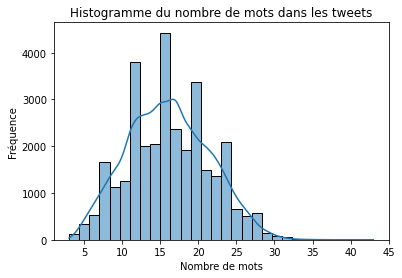

In [157]:
sns.histplot(df['word_count'], bins=30, kde=True)
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.title('Histogramme du nombre de mots dans les tweets')
plt.show()

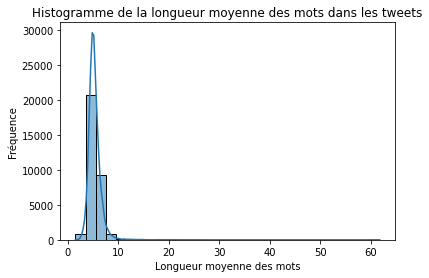

In [158]:
sns.histplot(df['mean_lpw'], bins=30, kde=True)
plt.xlabel('Longueur moyenne des mots')
plt.ylabel('Fréquence')
plt.title('Histogramme de la longueur moyenne des mots dans les tweets')
plt.show()

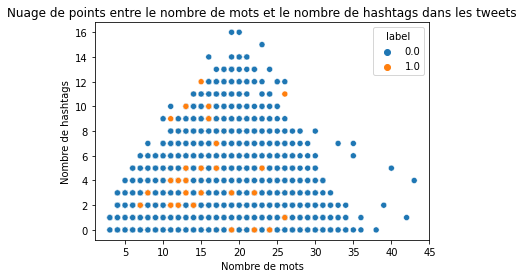

In [159]:
sns.scatterplot(x='word_count', y='hastags', data=df, hue=df["label"])
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de hashtags')
plt.title('Nuage de points entre le nombre de mots et le nombre de hashtags dans les tweets')
plt.show()

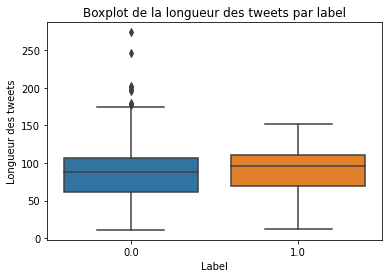

In [160]:
sns.boxplot(x='label', y='letters_count', data=df)
plt.xlabel('Label')
plt.ylabel('Longueur des tweets')
plt.title('Boxplot de la longueur des tweets par label')
plt.show()

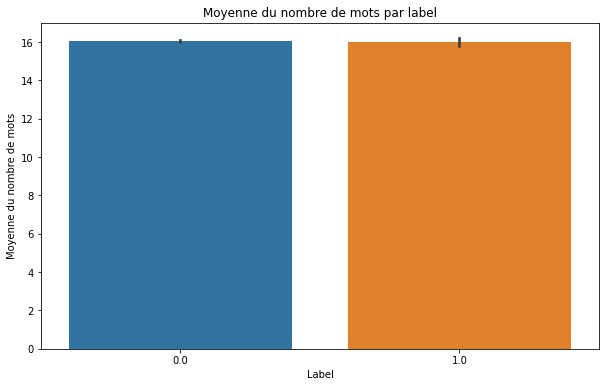

In [161]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='word_count', data=df)
plt.xlabel('Label')
plt.ylabel('Moyenne du nombre de mots')
plt.title('Moyenne du nombre de mots par label')
plt.show()

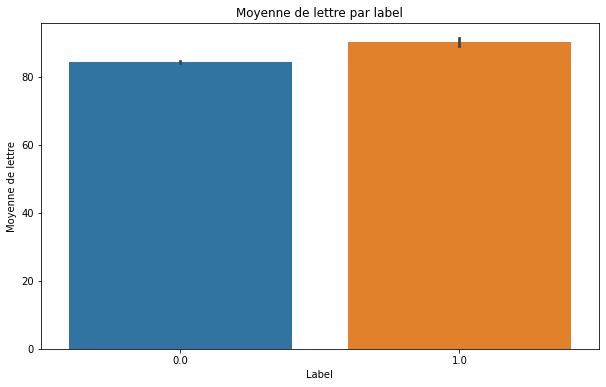

In [162]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='letters_count', data=df)
plt.xlabel('Label')
plt.ylabel('Moyenne de lettre')
plt.title('Moyenne de lettre par label')
plt.show()

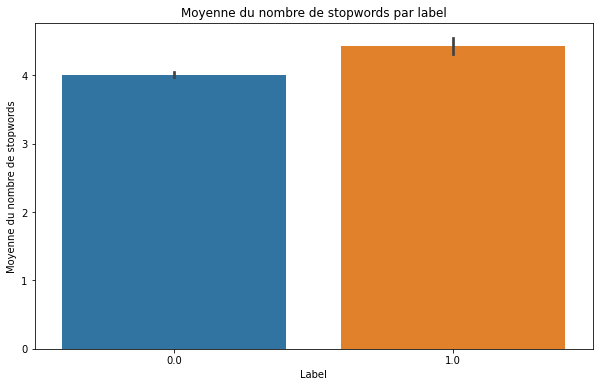

In [163]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='stopwords', data=df)
plt.xlabel('Label')
plt.ylabel('Moyenne du nombre de stopwords')
plt.title('Moyenne du nombre de stopwords par label')
plt.show()

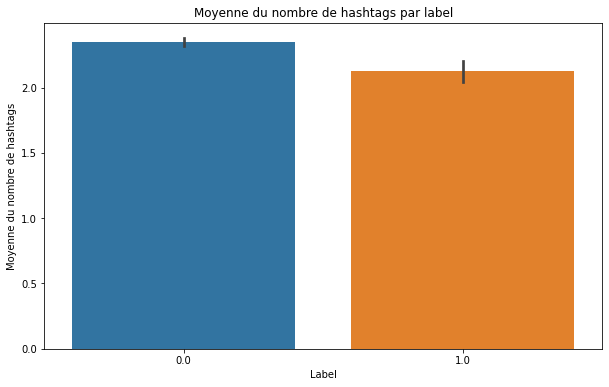

In [164]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='hastags', data=df)
plt.xlabel('Label')
plt.ylabel('Moyenne du nombre de hashtags')
plt.title('Moyenne du nombre de hashtags par label')
plt.show()

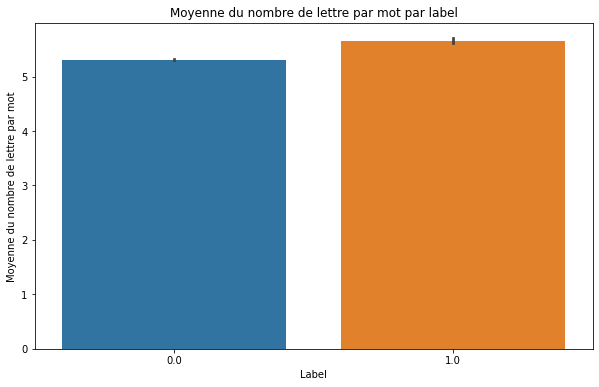

In [165]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='mean_lpw', data=df)
plt.xlabel('Label')
plt.ylabel('Moyenne du nombre de lettre par mot')
plt.title('Moyenne du nombre de lettre par mot par label')
plt.show()

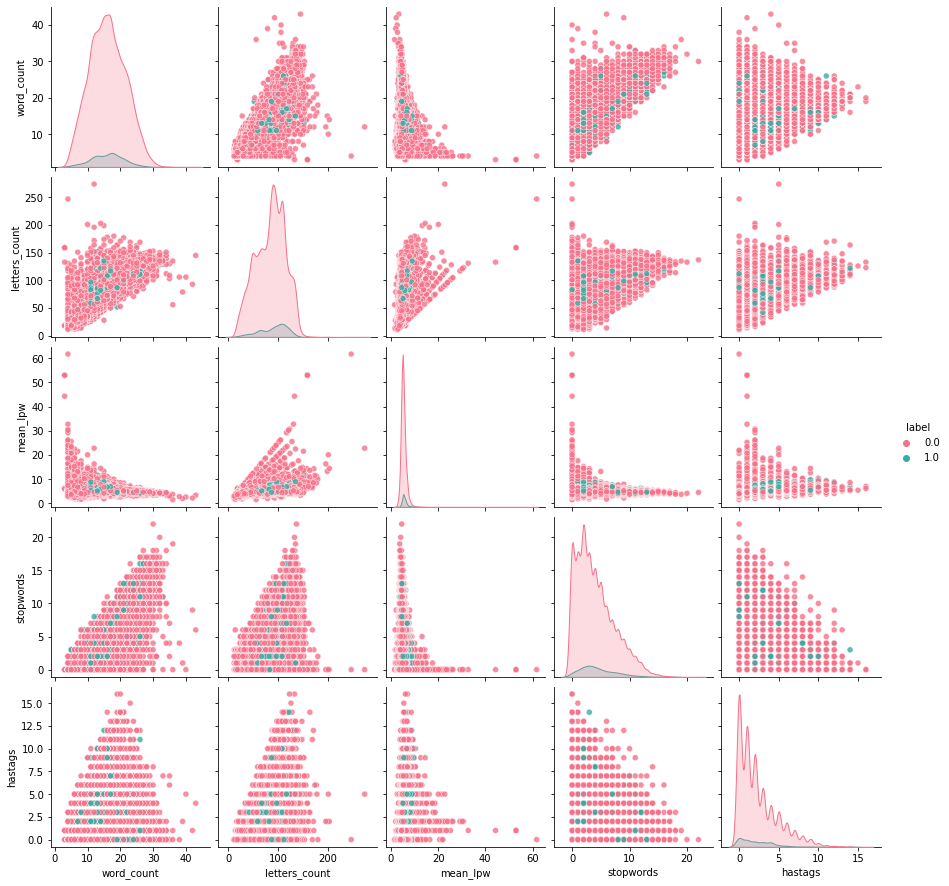

In [166]:
sns.pairplot(df.drop("tweet", axis = 1), hue='label', palette='husl', plot_kws={'alpha':0.8})
plt.show()

In [167]:
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags
id,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3
2,0.0,bihday majesty,5,21,4.200000,1,0
3,0.0,model take ur,17,86,5.058824,5,1
4,0.0,factsguide society motivation,8,39,4.875000,1,1
5,0.0,huge fan fare big talking leave chaos pay disp...,21,116,5.523810,6,1
...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu,6,68,11.333333,1,0
31958,0.0,see nina turner airwave trying wrap mantle gen...,25,131,5.240000,9,2
31959,0.0,listening sad song monday morning otw work sad,15,63,4.200000,5,0


#### Analyse des visualisations ####

On remarque malheuresement pas grand chose.

De toute les visualisations faites, on remarque qu'il n'y a pas grand permettant de séparer les tweets.

Nous allons devoir transformer encore plus la données pour trouver une corrélation permettant la classification

## Dernière tentative d'analyse :##

On essaye ici, de prendre toutes les valeurs extraites et de les normaliser pour essayer d'en faire une moyenne commune mais rien ne ressort.

In [168]:
df['word_count_normalized'] = (df['word_count'] - df['word_count'].min()) / (df['word_count'].max() - df['word_count'].min())
df['letters_count_normalized'] = (df['letters_count'] - df['letters_count'].min()) / (df['letters_count'].max() - df['letters_count'].min())
df['mean_lpw_normalized'] = (df['mean_lpw'] - df['mean_lpw'].min()) / (df['mean_lpw'].max() - df['mean_lpw'].min())
df['stopwords_normalized'] = (df['stopwords'] - df['stopwords'].min()) / (df['stopwords'].max() - df['stopwords'].min())
df['hashtags_normalized'] = (df['hastags'] - df['hastags'].min()) / (df['hastags'].max() - df['hastags'].min())
df['moyenne_normalisee'] = (df['word_count_normalized'] + df['letters_count_normalized'] + df['mean_lpw_normalized'] + df['stopwords_normalized'] + df['hashtags_normalized']) / 5
df

,label,tweet,word_count,letters_count,mean_lpw,stopwords,hastags,word_count_normalized,letters_count_normalized,mean_lpw_normalized,stopwords_normalized,hashtags_normalized,moyenne_normalisee
id,,,,,,,,,,,,,
1,0.0,thanks lyft credit can use cause offer wheelch...,22,122,5.545455,5,3,0.475,0.422053,0.066284,0.227273,0.1875,0.275622
2,0.0,bihday majesty,5,21,4.200000,1,0,0.050,0.038023,0.043932,0.045455,0.0000,0.035482
3,0.0,model take ur,17,86,5.058824,5,1,0.350,0.285171,0.058199,0.227273,0.0625,0.196629
4,0.0,factsguide society motivation,8,39,4.875000,1,1,0.125,0.106464,0.055145,0.045455,0.0625,0.078913
5,0.0,huge fan fare big talking leave chaos pay disp...,21,116,5.523810,6,1,0.450,0.399240,0.065924,0.272727,0.0625,0.250078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31957,0.0,ate isz youuu,6,68,11.333333,1,0,0.075,0.216730,0.162437,0.045455,0.0000,0.099924
31958,0.0,see nina turner airwave trying wrap mantle gen...,25,131,5.240000,9,2,0.550,0.456274,0.061209,0.409091,0.1250,0.320315
31959,0.0,listening sad song monday morning otw work sad,15,63,4.200000,5,0,0.300,0.197719,0.043932,0.227273,0.0000,0.153785


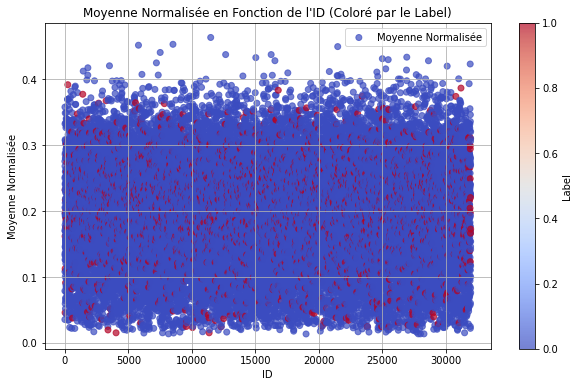

In [169]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['moyenne_normalisee'], c=df['label'], cmap='coolwarm', label='Moyenne Normalisée', alpha=0.7)
plt.xlabel('ID')
plt.ylabel('Moyenne Normalisée')
plt.title('Moyenne Normalisée en Fonction de l\'ID (Coloré par le Label)')
plt.colorbar(label='Label')
plt.legend()
plt.grid(True)
plt.show()

#### Vectorisation des mots ####

Avec Tifdf comme la dernière fois

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Selon les articles, pas de nécessité nécessaire d'inclure les autres paramètres

In [171]:
vec = TfidfVectorizer() 
X = vec.fit_transform(df["tweet"])
Y = df["label"]

In [172]:
xtrain,xtest,ytrain,ytest = train_test_split(X , df["label"], stratify=df["label"], random_state=42)
xtest

<7991x35390 sparse matrix of type '<class 'numpy.float64'>'
	with 57184 stored elements in Compressed Sparse Row format>

Voici une visualisation des vecteurs de mots colorisé selon leur label pour voir quelque chose, j'ai du le faire avec xtest et ytest (donc ceux qui font 20% du dataset) sinon datalore nous demande plus de mémoire.

On voit un peu plus de chose mais ca cela reste plutôt abstrait

Vu qu'il y a énormément de données, nous devons faire une pca pour pouvoir visualiser.

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(xtest.toarray())

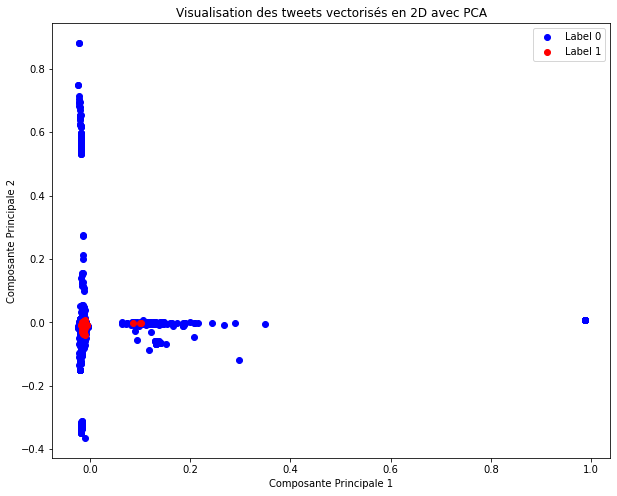

In [174]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[ytest == 0, 0], X_pca[ytest == 0, 1], color='blue', label='Label 0')
plt.scatter(X_pca[ytest == 1, 0], X_pca[ytest == 1, 1], color='red', label='Label 1')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Visualisation des tweets vectorisés en 2D avec PCA')
plt.legend()
plt.show()

In [175]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(xtest.toarray())

On tente une visualisation en 3d pour voir si il y a plus d'élèments à voir

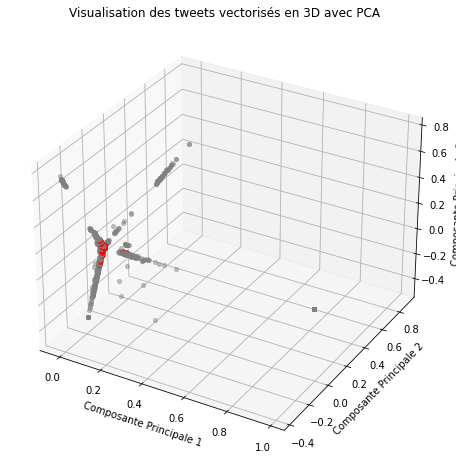

In [176]:
from mpl_toolkits.mplot3d import Axes3D

colors = {1: 'red',0:'gray'}
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ynp = ytest.to_numpy()
for i in range(len(X_pca_3d)):
    label_color = colors.get(ynp[i], 'gray')
    linewidth = 2 if ynp[i] == 1 else 0.5
    alpha = 1 if ynp[i] == 1 else 0.5
    ax.scatter(X_pca_3d[i, 0], X_pca_3d[i, 1], X_pca_3d[i, 2], c=label_color, linewidth=linewidth, alpha=alpha, marker='o')

ax.set_xlabel('Composante Principale 1')
ax.set_ylabel('Composante Principale 2')
ax.set_zlabel('Composante Principale 3')
plt.title('Visualisation des tweets vectorisés en 3D avec PCA')
plt.show()

On remarque que les tweets offensants se retrouve à la base des nouveaux axes

Mais avec énormément de tweet normaux dans les environs.

Vu que le dataset est toujours imbalanced, on va undersampler

In [177]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(xtrain, ytrain) #undersampler

In [178]:
Y_resampled

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
 ... 
3357 1.0
3358 1.0
3359 1.0
3360 1.0
3361 1.0
Name: label, Length: 3362, dtype: float64

On refait une pipeline, et on essaye de fit et faire la prédiction

In [179]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
]) #j'ai fait une pipeline, c un truc de bobo pour que ca s'enchaine sans devoir s'clc avec plein de variables

text_clf.fit(X_resampled,Y_resampled)

Pipeline(steps=[('tfidf', TfidfTransformer()), ('clf', MultinomialNB())]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline Pipeline(steps=[('tfidf', TfidfTransformer()), ('clf', MultinomialNB())]) TfidfTransformer TfidfTransformer() MultinomialNB MultinomialNB()

In [180]:
ypred = text_clf.predict(xtest)
ypred

array([1., 0., 0., ..., 0., 0., 0.])

In [181]:
metrics.confusion_matrix(ytest, ypred, normalize="true")

array([[0.83270525, 0.16729475],
 [0.09803922, 0.90196078]])

In [182]:
ft_printeur(ytest,ypred)

Accuraccy : 0.8375672631710674 
 Precision : 0.2893081761006289 
 F-1 Score : 0.2893081761006289


Les résultats sont plutôt bon pour la prédiction des tweets offensants, au final nous avons plus de mal à prédire les tweet normaux avec beaucoup de faux positif.
                                                                                                                

### 3Eme Tentative ###

Pendant nos recherches, une autre méthode a été assez discuté, le word embedding avec des modèles déjà pré entrainé.

Cela permet de vraiment représenter le mot en vecteurs, comme TFIDF mais cette fois ci sur le sens du mot et non seulement sur ca fréquence.

In [183]:
df_train = pd.read_csv("train.csv")

On reprends nos fonctions de traitements de la colone "tweets" (on retire : stopwords, caractères spéciaux, et tout ce qui sera inutil au traitement).

In [184]:
punct = string.punctuation
df_train["tweet"] = df_train["tweet"].apply(lambda x: str(x).translate(str.maketrans(punct, ' ' * len(punct))))
stop = set(stopwords.words('english'))

def remove_stopwords(text:str):
    l = str.split(text)
    for word in str.split(text):
        if word in stop :
            l.remove(word)
    return " ".join(l)

df_train["tweet"] = df_train["tweet"].apply(lambda x :remove_stopwords(str(x)))
def filtering(t, cw, rw) :
    words = t.split()
    filtered = [word for word in words if word not in cw and word not in rw]
    return " ".join(filtered)

commonwords = pd.Series(' '.join(df_train['tweet']).split()).value_counts()[:20]
rarewords = pd.Series(' '.join(df_train['tweet']).split()).value_counts()[-20:]
df_train['tweet'] = df_train['tweet'].apply(lambda x: filtering(x, commonwords, rarewords))
df_train["tweet"] = df_train["tweet"].apply(lambda x: ' '.join(word_tokenize(x)))
df_train["tweet"] = df_train["tweet"].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8'))

**Word Embedding, Train Test Split et UnderSampling :**

Le code ci-dessous est inspiré du site suivant : [Lien](https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381)

In [185]:
# Import des librairies
from sklearn.model_selection import train_test_split
import gensim

df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: gensim.utils.simple_preprocess(x)) # On créé une colonne ou les tweet sont sous la forme de liste de mots
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_tweet"] , df_train["label"], stratify=df_train["label"], test_size=0.2) # train test split

In [186]:
# Création du modèle ''mots à vecteur'' avec la librairie gensim
w2v_model = gensim.models.Word2Vec(X_train,  vector_size = 100, window = 5, min_count = 1)
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train], dtype='object')
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test], dtype='object')

In [187]:
# Ici on fait en sorte que chaque vecteur soit de la même taille
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [188]:
from sklearn.ensemble import RandomForestClassifier # import de RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel()) # entrainement du modèle sur nos données

In [189]:
y_pred = rf_model.predict(X_test_vect_avg) # Prédiction

In [191]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix # Affichage des socres et statistiques de la classification
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))
confusion_matrix(y_test, y_pred)

Precision: 0.938 / Recall: 0.234 / Accuracy: 0.945


array([[5938, 7],
 [ 343, 105]])

## OUVERTURE ##

N'ayant pas eu le temps de vouloir faire tout ce qu'on voulait, nous avons explorer d'autre possibilités pour comparer les résultats

Ci joint, ce qu'on voulait faire, issu majoritairement de ChatGPT :

- Essayer une prédiction purement issu de feature extraction, sans même utiliser les tweets

- Essayer une prédiction issu de feature extraction avec de la vectorisation de tweet et plusieurs modèles

In [192]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Séparer les caractéristiques et les labels
features = ['word_count_normalized', 'letters_count_normalized', 'mean_lpw_normalized', 'stopwords_normalized', 'hashtags_normalized']
X = df[features]
y = df['label']

# Diviser l'ensemble de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer SMOTE pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Créer et entraîner un modèle de classification (Random Forest dans cet exemple)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

metrics.confusion_matrix(y_test, y_pred, normalize="true")

Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      5955
         1.0       0.20      0.20      0.20       438

    accuracy                           0.89      6393
   macro avg       0.57      0.57      0.57      6393
weighted avg       0.89      0.89      0.89      6393



array([[0.93853904, 0.06146096],
 [0.79680365, 0.20319635]])

In [193]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

numeric_features = ['word_count_normalized', 'letters_count_normalized', 'mean_lpw_normalized', 'stopwords_normalized', 'hashtags_normalized']
text_feature = 'tweet'  # Nom de la colonne contenant le texte

# Créez un préprocesseur pour les caractéristiques numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Créez un préprocesseur pour la caractéristique textuelle
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'))
])

# Créez un preprocessor qui applique les préprocesseurs aux colonnes spécifiques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_feature)
    ])

# Exemple d'utilisation du preprocessor :
X_preprocessed = preprocessor.fit_transform(df)

y=df['label']

# Divisez l'ensemble de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Appliquez SMOTE sur l'ensemble d'entraînement pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Créez et entraînez un modèle de classification (Random Forest dans cet exemple)
# random forest : ok
# SVC linear = très bon
# Gradient boosting classifier nul
# XGBClassifier bof
# MLPCClassifer cool
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_resampled, y_resampled)

# Faites des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluez les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

metrics.confusion_matrix(y_test, y_pred, normalize="true")

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      5955
         1.0       0.53      0.75      0.62       438

    accuracy                           0.94      6393
   macro avg       0.75      0.85      0.79      6393
weighted avg       0.95      0.94      0.94      6393



array([[0.95029387, 0.04970613],
 [0.24885845, 0.75114155]])

Comme autre piste, nous avons aussi eu l'idée de refaire le word embeddings, mais cette fois ci en chargeant un modèle pré entrainé, le 'glove-twitter' qui est justement entrainé sur un datasets de tweeter.

https://radimrehurek.com/gensim/models/word2vec.html


Nous avons eu l'idée de compter les mots offensants les plus fréquents de notre dataset par tweet. Mais après discussions, nous avons jugés que cela aurait un trop gros risque d'overfitting.

## Conclusion ##

Le travail nous as énormément appris sur la gestion d'un projet de Data Science et de Machine Learning de A à Z.

Nous avons pris conscience de l'importance d'un bon traitement de données mais aussi de la recherche au préalable.

Il y a des dizaines de modèles différents a utiliser, mais sans bon traitement de données efficace au préalable, cela a beaucoup moins d'importances.

Avoir déjà l'idée d'un algorithme adapté au datasets en amont du traitement de donnée permet d'être beaucoup plus efficace dans le traitement de celle-ci.
